In [1]:
import pandas as pd
import numpy as np
from sargas import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline

# NPT

In [56]:
# Helper functions to build and run simulations

def build_npt(n, p, t, initial_density, rc, tail_correction):
    potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
    configuration = Configuration.from_lattice(n, initial_density)
    system = System(configuration, potential)
    displace_particle = MCMove.displace_particle(0.1, 0.4, t)
    change_volume = MCMove.change_volume(0.025, 0.5, p, t)
    
    mc = MonteCarlo([displace_particle, change_volume], [n, 1], t)
    simulation = Simulation.monte_carlo(system, mc, n)
    return simulation, system

def run_simulation(simulation, equilibration, production):
    simulation.run(equilibration)
    simulation.deactivate_propagator_updates()
    
    properties = Observer.properties(1000)
    simulation.add_observer(properties)
    
    simulation.run(production)
    return pd.DataFrame(properties.data)

def run_tp(t, p):
    nparticles = 500
    initial_density = 8e-1
    rc = 3.0
    tail_correction = True
    sim, sys = build_npt(500, p, t, initial_density, rc, True)
    properties = run_simulation(sim, 500*5000, 500*50000)
    return t, p, properties

In [71]:
%%time
states = [
    (8e-1, 8e-1),
    (9e-1, 8e-1)
]

with Pool() as pool:
    res = pool.starmap(run_tp, states)

CPU times: user 10.4 ms, sys: 72 ms, total: 82.4 ms
Wall time: 5min 51s


In [49]:
t1 = 9e-1
p1 = 8e-1
props1 = res[0]

t2 = 9e-1
p2 = 1.2
props2 = res[1]

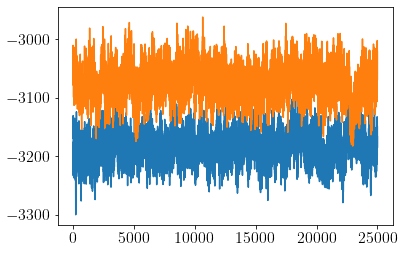

In [76]:
plt.plot(res[0][2].energy)
plt.plot(res[1][2].energy)

# Physical Validation

In [50]:
import physical_validation as pv

In [60]:
units = pv.data.UnitData(
    kb=1.0,
    energy_str='eps',
    energy_conversion=1.0,
    length_str='sigma',
    length_conversion=1.0,
    volume_str='sigma3',
    volume_conversion=1.0,
    temperature_str='T*',
    temperature_conversion=1.0,
    pressure_str='p*',
    pressure_conversion=1.0,
    time_str='t*',
    time_conversion=1.0
)

def simulation_data(t, p, data):
    nparticles = data.nparticles.values[0]
    sd = pv.data.SimulationData()
    sd.system = pv.data.SystemData(natoms=nparticles)
    sd.units = units
    sd.ensemble = pv.data.EnsembleData(
        ensemble="NPT",
        natoms=nparticles,
        pressure=p,
        temperature=t
    )
    sd.observables = pv.data.ObservableData(
        potential_energy=data.energy,
        volume=data.volume
    )
    return sd

In [72]:
sd = list(map(lambda x: simulation_data(*x), res))

In [73]:
pv.ensemble.check(
    data_sim_one=sd[0],
    data_sim_two=sd[1],
    screen=True
)

After equilibration, decorrelation and tail pruning, 0.93% (233 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 0.80% (201 frames) of original Trajectory 2 remain.
Overlap is 3.4% of trajectory 1 and 7.0% of trajectory 2.
Rule of thumb estimates that dT = 0.1 would be optimal (currently, dT = 0.1)


InputError: (['traj1', 'traj2', 'nbins', 'cutoff'], 'Less than 3 bins were filled in the overlap region.\nEnsure sufficient overlap between the trajectories, and consider increasing `cutoff` or `nbins` if there is sufficient overlap but unusually long tails.')